In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
from zipfile import ZipFile
import os

#uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
#zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
#zip_file = ZipFile(zip_path)
#zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

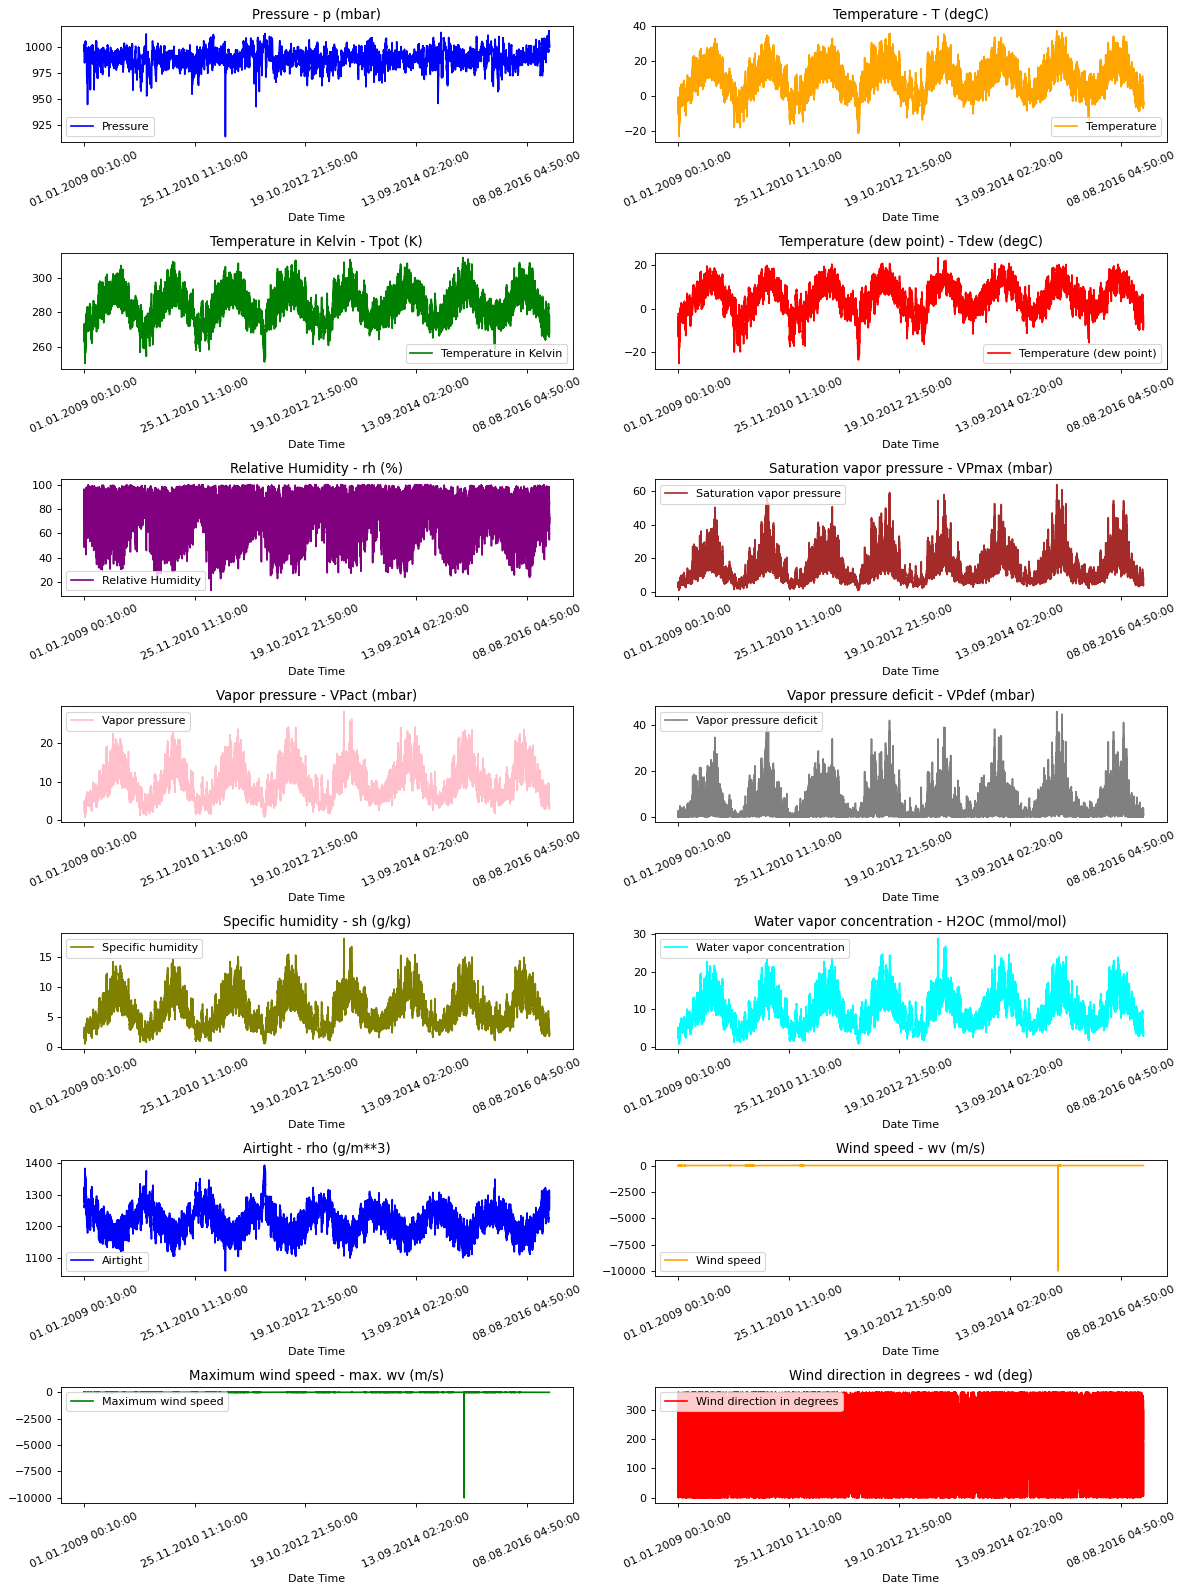

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

# Procesamiento de datos

Se trabajarán con algunas variable inicialmente, no con todas, es decir, se quitarán variables como Relative Humidity y Specific Humidity.

In [4]:
print(
    "Las variables seleccdionadas son:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

Las variables seleccdionadas son: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


Inicialmente se dividirán los datos en entrenamiento y  prueba y se definiran algunos parámetros importantes, como la configuración desde el aprendizaje supervisado, es decir, La idea será usar los 720 tiempos pasados(720/6=120 horas) para predecir los siguientes 72 putos del tiempos, es decir 72/6=12 horas. Se define una función patra la normalización. 

Los datos originalmente están medidos cada 10 minutos. Vamos a submuestrear 1 punto por hora, donde no se espera un cambio drástico en 60 minutos de las variables medidas, es decir, la frecuencia de medición será horaria. Esto se hará usando el argumento sampling_rate dentro de la función timeseries_dataset_from_array.

In [11]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6  ###Este parámetro es para el muestreo de las observaciones, en este caso se
##Toma cada 6 periodos del tiempo, para indicar una frecuencia horaria

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std



Inicialmente se normalizrán los datos para que todos restando la media y divieviendiendo entre la desviación estándar.

In [12]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()





,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


# Separación del conjunto de prueba y test

In [13]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

## Planteamiento del aprendizaje supervisado para el conjunto de prueba

Como se se requiren condiciones iniciales, 720 que conforman las covariables, mas un total de 72 pasos adelante, en total requerimos 792 observaciones para las condiciones iniciales para el conjunto de entrenamiento.

In [14]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [18]:
print(sequence_length)

120


La función timeseries_dataset_from_array toma una secuencia de puntos de datos recopilados a intervalos iguales, junto con parámetros de series temporales como la longitud de las secuencias/ventanas, el espacio entre dos secuencias/ventanas, etc., para producir lotes de entradas y objetivos de subseries temporales muestreado de las principales series temporales. Recordemos que depende del tamaño del lote las dimensiones.

In [15]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [17]:
i=1
for batch in dataset_train.take(2):
    inputs, targets = batch
    print("Covariable",i,inputs)
    print("Respuesta",i,targets)
    i=i+1

Covariable 1 tf.Tensor(
[[[ 0.95545114 -2.00002    -1.31978162 ... -1.50092673  2.23765845
   -0.73299722]
  [ 0.95302043 -1.95369698 -1.30545532 ... -1.46373892  2.18698961
   -1.28962415]
  [ 0.96882005 -2.09614026 -1.34713182 ... -1.5455521   2.34438122
   -1.30272125]
  ...
  [ 0.96274327 -2.26637736 -1.39141309 ... -1.72777235  2.5318804
    0.41954795]
  [ 1.01864962 -2.31501653 -1.40313461 ... -1.74264747  2.59943885
    0.38680519]
  [ 1.06483312 -2.45630174 -1.43569437 ... -1.77239771  2.76441855
   -0.01920504]]

 [[ 0.96152792 -2.04518494 -1.33280552 ... -1.51952063  2.28783773
   -0.93600233]
  [ 0.95302043 -1.95369698 -1.30545532 ... -1.4674577   2.18723439
   -1.28307559]
  [ 0.98218896 -2.09382411 -1.34582943 ... -1.54183332  2.34536033
   -1.17175021]
  ...
  [ 0.97854289 -2.27680004 -1.39401787 ... -1.73149113  2.54730135
    0.16415442]
  [ 1.02715711 -2.33122959 -1.40704178 ... -1.74636625  2.61926579
    0.25583415]
  [ 1.07577132 -2.47946325 -1.44090393 ... -1.7761

In [22]:
#for batch in dataset_train:
#    inputs, targets = batch
#    assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
#    assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
#    break

# Conjunto de Validación

Se hace lo mismo que para el conjunto de entrenamiento, pero se quitan los uíltimos 792 resgistros. Recordemos que están por tamaños del lote.

In [24]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

###Para el conjunto entrenamiento
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

###Para el conjunto de prueba
for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)
Input shape: (256, 120, 7)
Target shape: (256, 1)


## Estimación o entrenamiento

## Definición del modelo

In [25]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


Usaremos callback de ModelCheckpoint para guardar periódicamente los puntos de control, y callback de EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.


In [26]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2183
Epoch 1: val_loss improved from inf to 0.15506, saving model to model_checkpoint.h5
1172/1172 [==============================] - 62s 50ms/step - loss: 0.2183 - val_loss: 0.1551
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1258
Epoch 2: val_loss improved from 0.15506 to 0.14600, saving model to model_checkpoint.h5
1172/1172 [==============================] - 58s 50ms/step - loss: 0.1258 - val_loss: 0.1460
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1150
Epoch 3: val_loss did not improve from 0.14600
1172/1172 [==============================] - 61s 52ms/step - loss: 0.1150 - val_loss: 0.1475
Epoch 4/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1097
Epoch 4: val_loss did not improve from 0.14600
1172/1172 [==============================] - 61s 52ms/step - loss: 0.1096 - val_loss: 0.1488
Epoch 5/10
1172/1172 [========================

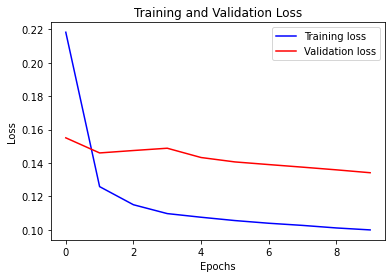

In [27]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

# Predicción

El modelo entrenado anterior ahora puede hacer predicciones para 5 conjuntos de valores del conjunto de validación.

8/8 [==============================] - 1s 5ms/step


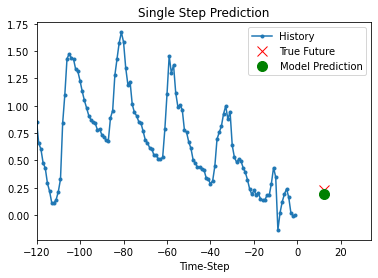

8/8 [==============================] - 0s 5ms/step


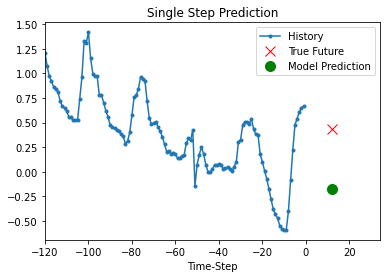

8/8 [==============================] - 0s 5ms/step


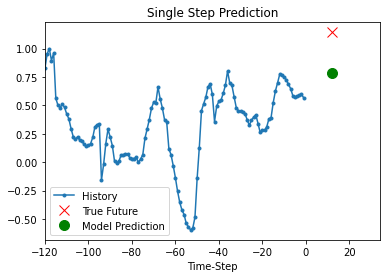

8/8 [==============================] - 0s 5ms/step


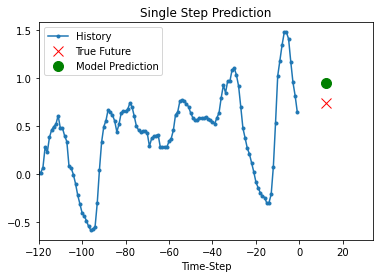

8/8 [==============================] - 0s 5ms/step


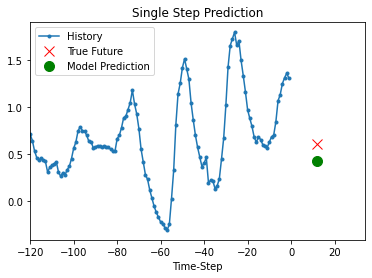

In [29]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


In [ ]:
errores=

In [ ]:
model.evaluate(X_test,y_test)

In [30]:
for x, y in dataset_val:
    model.predict(x)[0]
    

3/3 [==============================] - 0s 5ms/step
